#### Importando Bibliotecas

In [1]:
from collections import defaultdict
from pacman.actions import Actions
from pacman.env import PacmanEnv
from pacman.agents import Agent

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np

# Reinforcement Learning (MO436)

Autores:

**Aline Cavalca Caravlho Soares de Azevedo** (RA: )

**Beatriz Cardoso Nascimento**               (RA: )

**Daniel Gardin Gratti**                     (RA: 214729)

**Guilhermo de Luiggi Mocelim de Oliveira** (RA: )


## Introdução

Reinforcement Learning é um paradigma de Inteligência Artificial baseada em controle

In [3]:
env = PacmanEnv.contourDanger(4, ghost_names= "RobustGhost", state_space="features", render_mode="human")

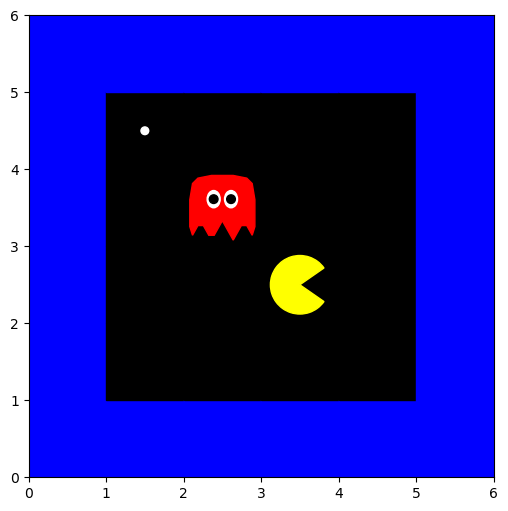

((2.0, 4.0), False)

In [4]:
env.reset()

In [6]:
def plot_episodes(history, metric:str, smooth=11, alpha=0.4):
    fig, ax = plt.subplots(figsize=(8, 5))

    episodes = np.array(history[metric])

    n_episode = np.array(range(len(episodes)))

    plt.plot(episodes, alpha=alpha)

    padded_episodes = np.pad(episodes, (smooth//2,smooth//2), 'edge')
    smooth_episodes = np.convolve(padded_episodes, np.ones(smooth)/smooth, mode='valid')

    ax.plot(smooth_episodes, linewidth=2)

    ax.set_title(f"{metric.capitalize()} during training")
    ax.set_ylabel(metric)
    ax.set_xlabel("episode")

    return fig, ax

In [7]:
from pacman.distributions import UniformDistribution

class RandomAgent(Agent):
    def get_distribution(self, state):
        return UniformDistribution(Actions.actions)

In [8]:
class EpsilonGreedyQAgent(Agent):
    """
    Agent with internal Q table and epsilon-greedy policy. Can learn from a control algorithm.
    """

    def __init__(self):
        self.Qtable = defaultdict(lambda : {action: 0. for action in Actions.actions})
    
    
    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            action, _ = self.max_Q(state)

        else:
            action = Actions.sample()

        return action


    def Q(self, state, action):
        return self.Qtable[state][action]
    

    def max_Q(self, state):
        action_values = self.Qtable[state]

        action = max(action_values, key=lambda k : action_values[k])

        return action, action_values[action]
    

    def update_Q(self, state, action, alpha, error):
        self.Qtable[state][action] += alpha * error


    def reset(self):
        """
        Reset agent's Q table.
        """
        self.Qtable.clear()

In [9]:
class BaseController:
    def __init__(self, env):
        self.env    = env

    def train(self, policy, max_episodes):
        pass


### Monte Carlo

In [11]:
class MonteCarloControl(BaseController):
    def __init__(self, env, gamma, alpha=None, N0=1):
        super().__init__(env)

        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0
    

    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):

            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0
            n_steps           = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)

                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1
               
                cumulative_reward = (self.gamma * cumulative_reward) + reward

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha
                error = (cumulative_reward - policy.Q(state, action))
                policy.update_Q(state, action, alpha, error)

                cumulative_error += abs(error)

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(env.is_win())

        
        return policy, history

In [ ]:
monte_carlo = MonteCarloControl(env.set_render(None), 0.99)
mc_policy = EpsilonGreedyQAgent()
scores = np.zeros([49,100])

for i in range (1,50):
    monte_carlo.N0 = i
    _, mc_history = monte_carlo.train(mc_policy, 10000)

    #print(scores)

    for j in range(100):
        env.run_policy(mc_policy, 0, 0)
        scores[i-1][j] =  env.get_score()

    mc_policy.reset()

media = np.mean(scores, 1)
print(media)

In [ ]:
best_n0 = []
for i in range (0,49):
    if media[i] >= 43:
        best_n0.append(i)

best_n0

In [ ]:
monte_carlo = MonteCarloControl(
    env    = env.set_render(None),
    gamma  = 0.99,
    N0     = best_n0[0]
)
mc_policy, mc_history = monte_carlo.train(EpsilonGreedyQAgent(), 1000)

In [ ]:
env.set_render('human')
env.run_policy(mc_policy, 0, .5);

In [ ]:
plot_episodes(mc_history, "cumulative reward", smooth=100)

### Q-Learning

In [35]:
class QLearning(BaseController):
    def __init__(self, env, gamma, alpha=None, N0=1):
        super().__init__(env)

        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0

    
    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):
            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)
                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                _, Qmax = policy.max_Q(next_state)

                td_error = reward + self.gamma * Qmax - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha

                policy.update_Q(state, action, alpha, td_error)

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(env.is_win())

        return policy, history

In [ ]:
q_learning = QLearning(env.set_render(None), 0.99)
q_policy = EpsilonGreedyQAgent()
scoresQ = np.zeros([49,100])

for i in range (1,50):
    q_learning.N0 = i
    _, q_history = q_learning.train(q_policy, 10000)

    #print(scores)

    for j in range(100):
        env.run_policy(q_policy, 0, 0)
        scoresQ[i-1][j] =  env.get_score()

    q_policy.reset()

mediaQ = np.mean(scoresQ, 1)
print(mediaQ)

In [36]:
q_learning = QLearning(
    env    = env.set_render(None),
    gamma  = 0.99,
    N0     = 10
)
q_policy, q_history = q_learning.train(EpsilonGreedyQAgent(), 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
env.set_render('human')
env.run_policy(q_policy, 0, .5);

% % % % % %
% < M     %
%         %
%         %
%         %
% % % % % %
Score: 43


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Cumulative reward during training'}, xlabel='episode', ylabel='cumulative reward'>)

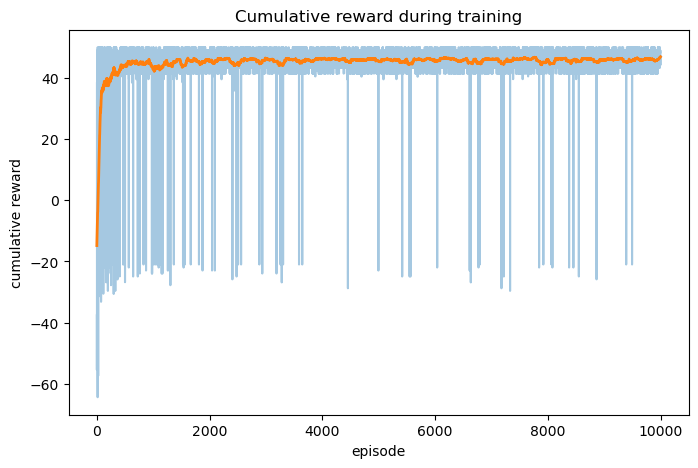

In [62]:
plot_episodes(q_history, "cumulative reward", smooth=101)

### SARSA($\lambda$)

In [39]:
class SARSA(BaseController):
    def __init__(self, env, gamma, lmbda, alpha=None, N0=1):
        super().__init__(env)

        self.gamma = gamma
        self.lmbda = lmbda
        self.alpha = alpha
        self.N0    = N0


    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):
            
            Etable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

            state, done = self.env.reset(random_init = True)
            action = policy.act(state, epsilon=1)

            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                Etable[state][action] = Etable[state][action] + 1

                next_state, reward, done, info = self.env.step(action)

                epsilon = self.N0 / (self.N0 + sum(Ntable[next_state].values()))

                next_action = policy.act(next_state, epsilon)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                td_error = reward + self.gamma * policy.Q(next_state, next_action) - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha

                for state in Etable:
                    for action in Actions.actions:
                        policy.update_Q(state, action, alpha, td_error * Etable[state][action])
                        Etable[state][action] *= self.gamma * self.lmbda

                state  = next_state
                action = next_action

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(env.is_win())
        
        return policy, history

In [ ]:
sarsa = SARSA(env.set_render(None), 0.99,0.2)
sarsa_policy = EpsilonGreedyQAgent()
scoresSarsa = np.zeros([49,100])

for i in range (1,50):
    sarsa.N0 = i
    _, sarsa_history = sarsa.train(sarsa_policy, 10000)

    #print(scores)

    for j in range(100):
        env.run_policy(sarsa_policy, 0, 0)
        scoresSarsa[i-1][j] =  env.get_score()

    sarsa_policy.reset()

mediaSarsa = np.mean(scoresSarsa, 1)
print(mediaSarsa)

In [40]:
sarsa = SARSA(
    env    = env.set_render(None),
    gamma  = 0.99,
    lmbda  = 0.2,
    N0     = 10
)
sarsa_policy, sarsa_history = sarsa.train(EpsilonGreedyQAgent(), 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
env.set_render('human')
env.run_policy(sarsa_policy, 0, .5);

% % % % % %
% < M     %
%         %
%         %
%         %
% % % % % %
Score: 45


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Episode win during training'}, xlabel='episode', ylabel='episode win'>)

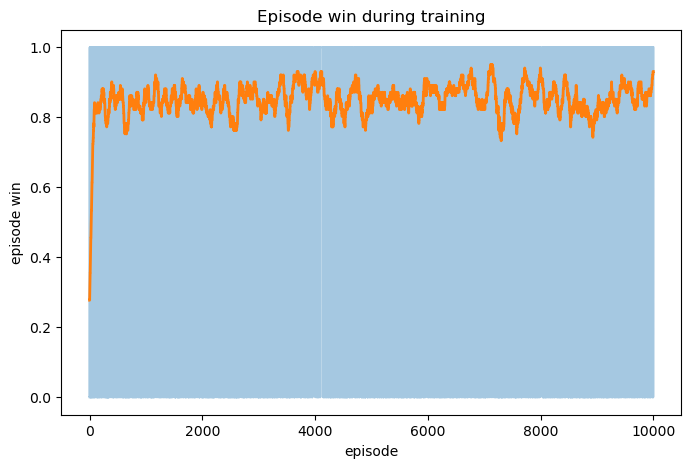

In [64]:
plot_episodes(sarsa_history, "episode win", smooth=101)

## Linear Features

In [23]:
class EpsilonGreedyLinearAgent(Agent):
    """
    Agent with linear approximation for Q and epsilon-greedy policy.
    This class do not include any default training algorithm.
    """

    def __init__(self, state_dim, action_dim):
        self.weights = np.random.randn(action_dim, state_dim)
    
    
    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            action, _ = self.max_Q(state)

        else:
            action = Actions.sample()

        return action


    def Q(self, state, action):
        idx = Actions.action_index(action)

        return (self.weights @ np.array(state))[idx]


    def max_Q(self, state):
        Qvalues = self.weights @ np.array(state)

        idx = np.argmax(Qvalues)

        return Actions.actions[idx], Qvalues[idx]


    def update_Q(self, state, action, alpha, error):
        bellman_loss_grad = np.array(state)

        self.weights += alpha * error * bellman_loss_grad


    def reset(self):
        """
        Reset agent's Q table.
        """
        self.weights = np.random.randn(*self.weights.shape)

In [24]:
linear_env = PacmanEnv.contourDanger(4, ghost_names="RobustGhost", state_space="features")

monte_carlo = MonteCarloControl(
    env    = linear_env.set_render(None),
    gamma  = 0.99,
    alpha  = 0.1,
)
mc_policy, mc_history = monte_carlo.train(EpsilonGreedyLinearAgent(2, 4), 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [67]:
q_learning = QLearning(
    env    = linear_env.set_render(None),
    gamma  = 0.99,
    N0     = 10
)
q_policy, q_history = q_learning.train(EpsilonGreedyLinearAgent(2, 4), 10000)